# Flower Classification with VGG16
### Author: Salma OUARDI
Dataset: [Flowers Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

### On import la base de données depuis Kaggle

In [6]:
%pip install kaggle
%pip install pandas
%pip install seaborn
%pip install scipy


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle datasets download alxmamaev/flowers-recognition
# ! unzip flowers-recognition.zip

In [8]:
!rm /root/.keras/datasets/flower_photos/LICENSE.txt
# !ls -l /root/.keras/datasets/flower_photos

!rm -rf /kaggle/working/dataset
!cp -r /root/.keras/datasets/flower_photos/ /kaggle/working/dataset
!ls -l /kaggle/working/dataset

DATASET_DIR = '/kaggle/working/dataset'

rm: cannot remove '/root/.keras/datasets/flower_photos/LICENSE.txt': Permission denied
cp: cannot stat '/root/.keras/datasets/flower_photos/': Permission denied
ls: cannot access '/kaggle/working/dataset': No such file or directory


### On verifie qu'on a un GPU 

In [9]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

2024-11-21 18:08:13.720917: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 18:08:13.720981: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


''

In [10]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

ln: failed to create symbolic link '/usr/bin/nvidia-smi': Permission denied
  Using cached GPUtil-1.4.0-py3-none-any.whl

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
  Using cached humanize-4.11.0-py3-none-any.whl (128 kB)

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Gen RAM Free: 12.7 GB  | Proc size: 611.4 MB
GPU RAM Free: 3239MB | Used: 716MB | Util  17% | Total 4096MB


### On import les librairies

In [11]:
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg

import tensorflow as tf
print(tf.__version__)
# tensorflow 2.16 allows 
# from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

from keras.utils import load_img, img_to_array
from keras import optimizers

from keras import layers
from keras import models
from keras import optimizers


2.16.1


In [12]:
!rm -rf /home/logic/.keras/datasets/flower_photos_extracted

import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)

print(data_dir)

data_dir = pathlib.Path(data_dir).with_suffix('')
data_dir

/home/logic/.keras/datasets/flower_photos_extracted


PosixPath('/home/logic/.keras/datasets/flower_photos_extracted')

In [13]:
# original dataset folder, you can see above
DATASET_DIR = data_dir

flowers_path = str(pathlib.Path(DATASET_DIR)) +'/flower_photos'
flowers_path

# clean up the path
!rm -rf {flowers_path}/LICENSE.txt

In [15]:
# Check for the directory and if it doesn't exist, make one.
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
    
# make the models sub-directory
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

## On prepare explore la dataset

In [16]:
# Each species of flower is contained in a separate folder. Get all the sub directories
flower_types = os.listdir(flowers_path)
print("Types of flowers found: ", len(flower_types))
print("Categories of flowers: ", flower_types)

Types of flowers found:  5
Categories of flowers:  ['daisy', 'dandelion', 'sunflowers', 'tulips', 'roses']


In [17]:
# A list that is going to contain tuples: (species of the flower, corresponding image path)
flowers = []

for species in flower_types:
    # Get all the file names
    all_flowers = os.listdir(flowers_path +"/"+ species)
    # Add them to the list
    for flower in all_flowers:
        flowers.append((species, str(flowers_path +"/"+species) + '/' + flower))

# Build a dataframe        
flowers = pd.DataFrame(data=flowers, columns=['category', 'image'], index=None)
flowers.head()

,category,image
0,daisy,/home/logic/.keras/datasets/flower_photos_extr...
1,daisy,/home/logic/.keras/datasets/flower_photos_extr...
2,daisy,/home/logic/.keras/datasets/flower_photos_extr...
3,daisy,/home/logic/.keras/datasets/flower_photos_extr...
4,daisy,/home/logic/.keras/datasets/flower_photos_extr...


In [18]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowers))
fl_count = flowers['category'].value_counts()
print("Flowers in each category: ")
print(fl_count)

Total number of flowers in the dataset:  3670
Flowers in each category: 
category
dandelion     898
tulips        799
sunflowers    699
roses         641
daisy         633
Name: count, dtype: int64


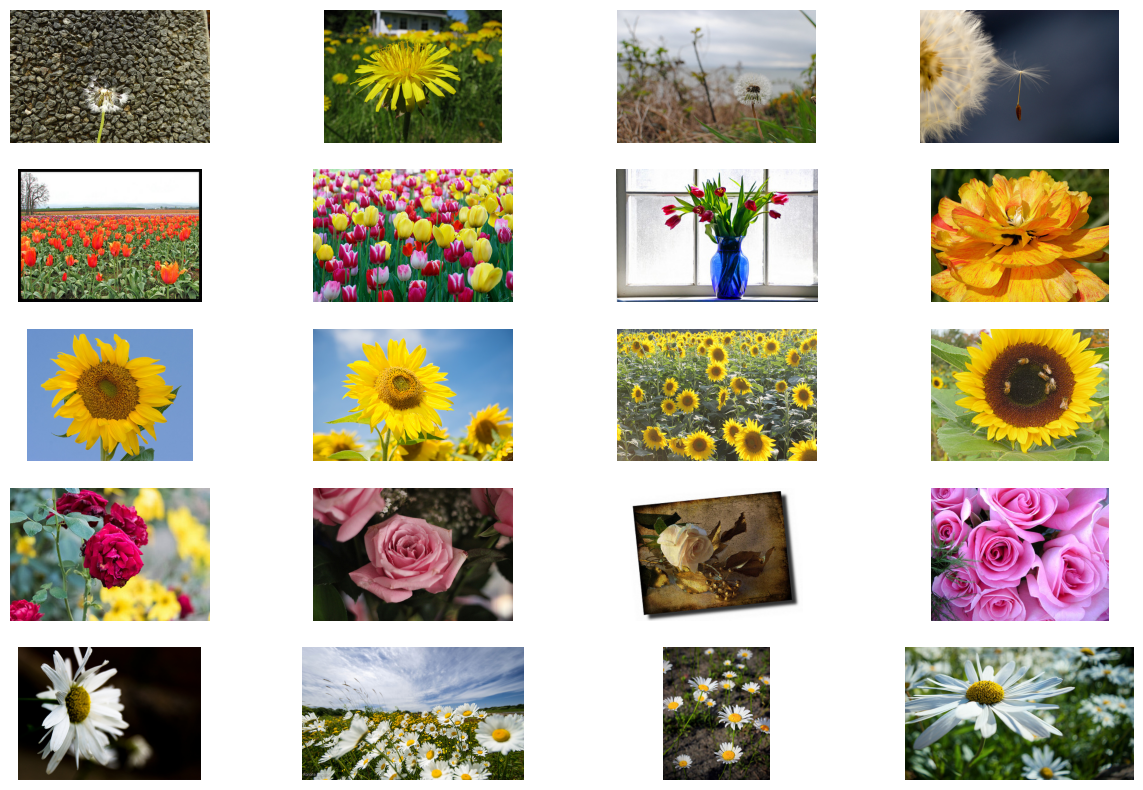

In [19]:
# Let's visualize some flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)

# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show()    

### On va créer deux dossier 'Train' et 'Valid' pour notre modéle

In [20]:
# Make a parent directory `data` and two sub directories `train` and `valid`
%mkdir -p data/train
%mkdir -p data/valid

# Inside the train and validation sub=directories, make sub-directories for each catgeory
%cd data
%mkdir -p train/daisy
%mkdir -p train/tulips
%mkdir -p train/sunflowers
%mkdir -p train/roses
%mkdir -p train/dandelion

%mkdir -p valid/daisy
%mkdir -p valid/tulips
%mkdir -p valid/sunflowers
%mkdir -p valid/roses
%mkdir -p valid/dandelion

%cd ..

/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data


/home/logic/.pyenv/versions/3.9.20/envs/jupyter-tf-kaggle/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/logic/_wsl_workspace/google-colab-playlist/kaggle


### On import nos catégories dans les deux dossiers 

In [21]:
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].values
    #perm = np.random.permutation(samples)
    # Copy first 100 samples to the validation directory and rest to the train directory

    print(samples[0])
    
    for i in range(100):
        name = samples[i].split('/')[-1]
        shutil.copyfile(samples[i],'./data/valid/' + str(category) + '/'+ name)
    for i in range(100,len(samples)):
        name = samples[i].split('/')[-1]
        shutil.copyfile(samples[i],'./data/train/' + str(category) + '/' + name)

/home/logic/.keras/datasets/flower_photos_extracted/flower_photos/dandelion/2596413098_7ef69b7e1d_m.jpg
/home/logic/.keras/datasets/flower_photos_extracted/flower_photos/tulips/8712282563_3819afb7bc.jpg
/home/logic/.keras/datasets/flower_photos_extracted/flower_photos/sunflowers/4689061249_6498da5013.jpg
/home/logic/.keras/datasets/flower_photos_extracted/flower_photos/roses/3829990289_c0c3821e4d_m.jpg
/home/logic/.keras/datasets/flower_photos_extracted/flower_photos/daisy/3468498624_d082f99e98.jpg


### Comme modéle, on utilise VGG16 qui est un modéle Pretrained

In [22]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(240, 240, 3))

2024-11-21 18:08:30.552385: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-21 18:08:30.552437: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [23]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
base_dir = './data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')

## Feature Extraction

In [25]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,626,565 (105.39 MB)

 Trainable params: 27,626,565 (105.39 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
batch_size = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(240, 240),  # all images will be resized to 240x240
        batch_size=batch_size,
        class_mode='categorical')  # more than two classes

validation_generator = test_datagen.flow_from_directory(
        'data/valid',
        target_size=(240, 240),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)

Found 3170 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [28]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

In [ ]:
history = {}

history = model.fit(
  train_generator,
  epochs=2, # originally 30 epochs
  validation_data=validation_generator)

Epoch 1/2
  2/100 ━━━━━━━━━━━━━━━━━━━━ 21:31 13s/step - acc: 0.1719 - loss: 1.6492

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [ ]:
model_2_val = val_acc[-1]
print("Validation Accuracy: ", model_2_val)

# Fine Tuning

In [ ]:
conv_base.summary()

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics=['acc'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=3,# originally 6 epochs
    validation_data=validation_generator,
    validation_steps=50)

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [ ]:
model_3_val = val_acc[-1]
print("Validation Accuracy: ", model_3_val)

### 85% Accuracy using VGG16.